In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime 
%matplotlib inline

In [2]:
df = pd.read_csv('data/food-box-metrics.csv')

df.head(3)

,customer,distribution_method,date,planned_method,final_method,completed_at,last_box_date,weekday,hour,morning_afternoon,is_unenrolled,deviation_from_plan,deviation_from_current,deviation_summary
0,Customer 3,pickup,2022-06-24,pickup,pickup,2022-06-25 11:45:05-04:00,NaN,Saturday,11,Morning,False,0,0,as planned
1,Customer 53,pickup,2022-06-24,pickup,pickup,2022-06-24 17:03:31-04:00,NaN,Friday,17,Afternoon,False,0,0,as planned
2,Customer 51,pickup,2022-06-24,pickup,pickup,2022-06-24 16:08:30-04:00,NaN,Friday,16,Afternoon,False,0,0,as planned


## Multiple subplots with trend lines

Prepare the data...

In [3]:
# get counts per date, weekday, and am/pm for plotting
pickups_only_mask = df['final_method'] == 'pickup'
ampm_df = df[pickups_only_mask].groupby(['date', 'weekday', 'morning_afternoon'], as_index=False).size()
ampm_df.rename(columns={'size': 'count'}, inplace=True)
ampm_df['timeslot'] = ampm_df['weekday'].astype(str) + ' ' + ampm_df['morning_afternoon'].astype(str)
ampm_df['date'] = pd.to_datetime(ampm_df['date'])
ampm_df.head()

,date,weekday,morning_afternoon,count,timeslot
0,2022-06-24,Friday,Afternoon,5,Friday Afternoon
1,2022-06-24,Friday,Morning,3,Friday Morning
2,2022-06-24,Saturday,Afternoon,8,Saturday Afternoon
3,2022-06-24,Saturday,Morning,6,Saturday Morning
4,2022-07-01,Friday,Afternoon,7,Friday Afternoon


Set up the figure, axes, and needed variables

Text(0.5, 0.98, 'Morning/Afternoon Pickups')

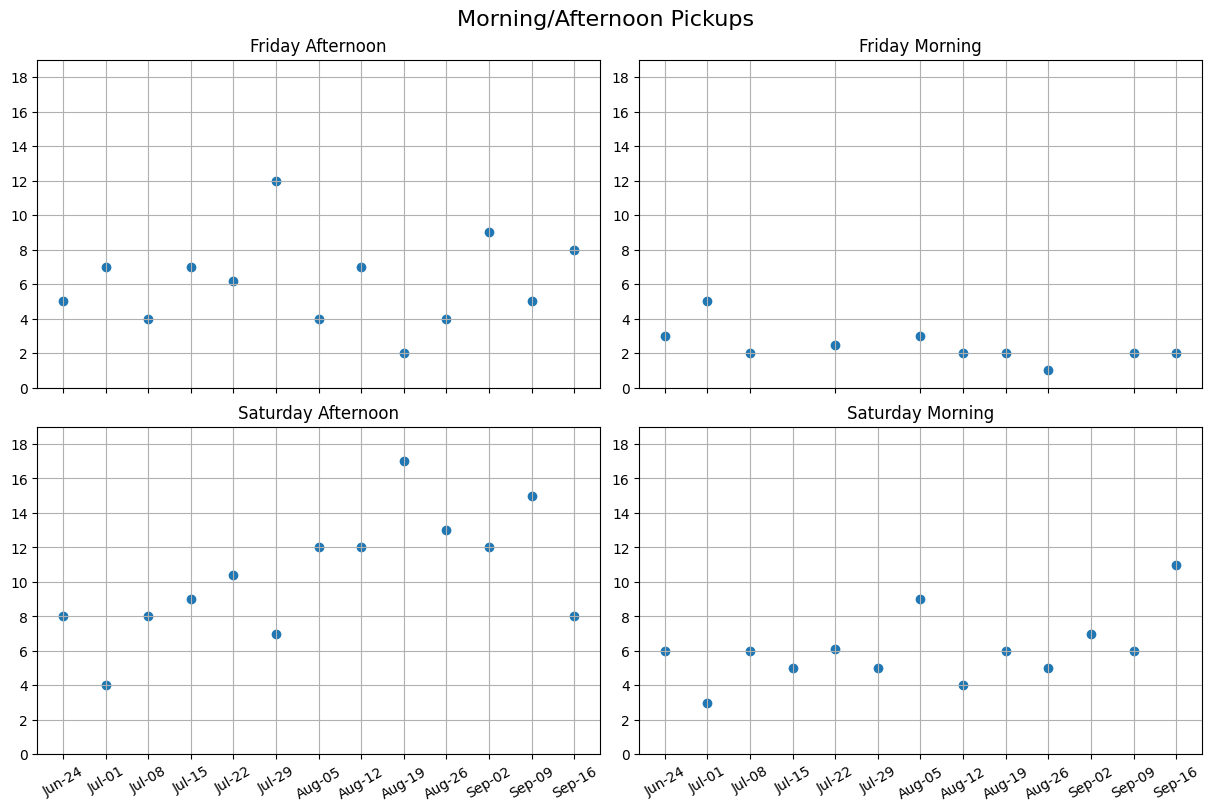

In [65]:
# constrained_layout automatically adjusts subplots and legends so they fit in the figure window
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), constrained_layout=True)

# flatten list of axes
axes = axes.reshape(-1)

# 4 separate time slots to plot
timeslots = list(ampm_df['timeslot'].unique())

# maximum for the y axis
ymax = ampm_df['count'].max() + 2

for i, ax in enumerate(axes):
    # create a df for the plot with the filtered rows, and only the necessary columns
    plot_df = ampm_df.loc[ampm_df['timeslot'] == timeslots[i],['date', 'count']]
    plot_df.set_index('date', inplace=True)

    # temporary fix for missing 2022-07-22 data - fill in with mean for each group
    avg_fill = plot_df['count'].mean()
    plot_df.loc[datetime(2022,7,22)] = {'count': avg_fill}
    plot_df.sort_index(inplace=True)
    
    # plot the box counts 
    ax.scatter(plot_df.index, plot_df['count'])
    ax.set_ylim(bottom=0, top=ymax)
    ax.set_title(timeslots[i])
    
    # set y ticks to all even numbers
    ax.set_yticks(np.arange(0,ymax, 2))
    
    # set x ticks to every date
    ax.set_xticks(plot_df.index)
    ax.set_xticklabels(ax.get_xticks(), rotation = 30)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

    # restore xlims
    ax.set_xlim(x_low, x_high)
    
    # turn on the grid
    ax.grid(True)

# add a figure-level legend
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
fig.suptitle('Morning/Afternoon Pickups', fontsize=16)

## Plot with max line and best fit

In [59]:
# create a DataFrame of just Saturday pickups with counts per date
mask = (df['weekday'] == 'Saturday') & (df['final_method'] == 'pickup')
plot2_df = df[mask].groupby('date', as_index=False).size()
plot2_df.rename(columns={'size': 'count'}, inplace=True)
plot2_df['date'] = pd.to_datetime(plot2_df['date'])

[19167. 19174. 19181. 19188. 19202. 19209. 19216. 19223. 19230. 19237.
 19244. 19251.]


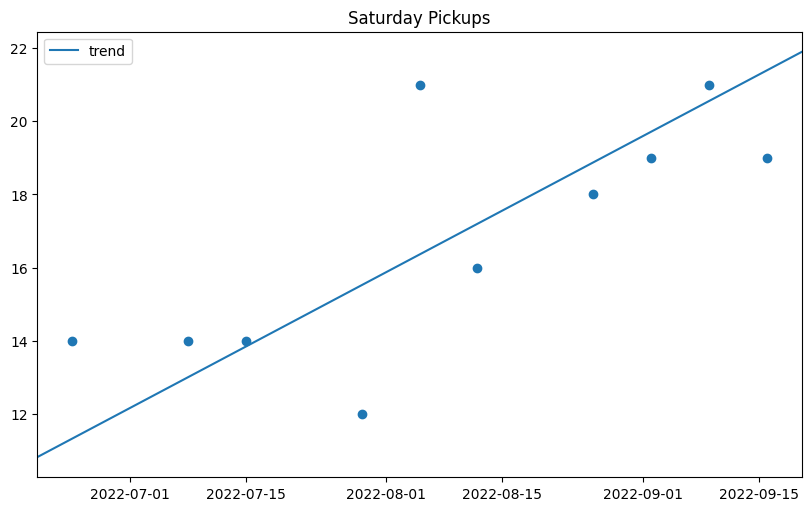

In [67]:
# set up the basic figure and axis
fig2, ax2 = plt.subplots(figsize=(8,5), constrained_layout=True)
ax2.set_title('Saturday Pickups')

# scatter plot of dates with their counts
ax2.scatter(plot2_df['date'], plot2_df['count'])

# convert the dates to numbers for the polyfit calculation
x1 = mdates.date2num(plot2_df['date'])
print(x1)

# create a best fit trend line using the numbers and the counts
trend = np.polyfit(x1, plot2_df['count'], deg=1)

# create an equation function from the trend line that will convert x to y
poly_eqn = np.poly1d(trend)

# get the x limits of the chart and prepare x values that stretch from edge to edge
x_low, x_high = ax.get_xlim()
x2 = np.linspace(x_low, x_high, 10)

# calculate the corresponding y values
y2 = poly_eqn(x2)

# plot the trend line by converting the x values back to dates
ax2.plot(mdates.num2date(x2), y2, label='trend')

# reset the xlimits, so no additional margin is added
ax2.set_xlim(mdates.num2date(x_low), mdates.num2date(x_high))

# add the legend
ax2.legend()